### Notebook to identify EOA targets from rotation curve targets

In [3]:
import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300

In [4]:
DATA_DIRECTORY = '/pscratch/sd/n/nravi/pv_rot_curves/'

In [5]:
# load master table
# NOTE: update fuji and iron tables after identifying targets
tf_master_table = Table.read(DATA_DIRECTORY + 'desi_pv_tf_master_table_healpix_rotcurve.fits')
tf_master_table[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136,1.0,0.012960487467698754,0.3300000056318236,0.0
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595,1.0,0.012960487467685656,0.33000000563149007,0.0
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195,1.0,0.026313716979861984,0.6700000114340222,0.0


In [6]:
# load SGA
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [6]:
# add cols to table
tf_master_table['TARGET_DELTA_PA'] = np.nan*np.ones(len(tf_master_table)) # column for difference between position angle of target and semi-major axis
tf_master_table['EOA'] = 0. # flag for EOA targets

# create SGA dict
SGA_dict={}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

In [7]:
# calculate angle between target and semi-major axis of galaxy 'Cosmicflows4_comparison-ITFR_KAD.ipynb'

for sga_gal in np.unique(tf_master_table['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tf_master_table['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    # define center and target coords
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=tf_master_table['TARGET_RA'][obs_idx], 
                             dec=tf_master_table['TARGET_DEC'][obs_idx], 
                             unit=u.degree)
    
    
    # Compute the position angle from the center to the observation
    pa = center_coords.position_angle(target_coords).to(u.deg)

    # Compute the difference between these position angles and that of the 
    # major axis
    delta_pa = np.abs(pa - SGA['PA'][sga_idx]*u.deg)

    tf_master_table['TARGET_DELTA_PA'][obs_idx] = delta_pa

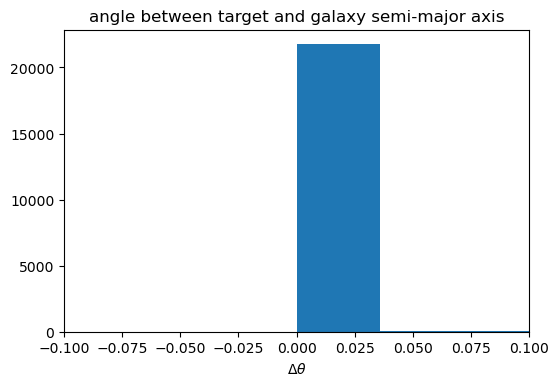

In [8]:
vals, bins, _ = plt.hist(tf_master_table['TARGET_DELTA_PA']%180, 
                         bins=5000
                        )
plt.xlabel(r'$\Delta \theta$')
plt.xlim(-0.1,0.1)
plt.title('angle between target and galaxy semi-major axis')
plt.show()

In [18]:
bins

array([0.00000e+00, 3.60000e-02, 7.20000e-02, ..., 1.79928e+02,
       1.79964e+02, 1.80000e+02])

In [19]:
tf_master_table[tf_master_table['TARGET_DELTA_PA'] %180 > 0.036]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,TARGET_DELTA_PA,EOA
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64
1092231427522560,208.352177440161,5.20876513433155,26432,sv3,0.00303767701971418,7.77079295855834e-05,0,60.6499349754095,fuji/healpix/sv3/dark/264/26432/redrock-sv3-dark-26432.fits,EXT,560867,208.35217744016057,5.2087651343315455,1.0,0.008471934698375589,0.3300000031866702,0.0,179.9999988110148,0.0
1084530156896264,189.911775799758,61.6325590126154,11227,sv3,0.000628693143921693,3.93518120598964e-05,0,45.9865862018414,fuji/healpix/sv3/dark/112/11227/redrock-sv3-dark-11227.fits,EXT,594346,189.9117757997579,61.63255901261535,1.0,0.04765810707938051,0.6699999580649858,0.0,179.999995494522,0.0
1088925321920514,189.955801348671,61.6204271358126,11227,sv3,0.000771031425195882,1.93071063616644e-05,0,731.954300085962,fuji/healpix/sv3/dark/112/11227/redrock-sv3-dark-11227.fits,EXT,594346,189.95580134867072,61.62042713581259,1.0,0.02347339602443028,0.32999997934906494,0.0,179.99999549569623,0.0
1084527275409415,189.955801348671,61.6204271358126,11227,sv3,0.000719206890656024,8.25881030944722e-06,0,6052.09266010874,fuji/healpix/sv3/dark/112/11227/redrock-sv3-dark-11227.fits,EXT,594346,189.95580134867072,61.62042713581259,1.0,0.02347339602443028,0.32999997934906494,0.0,179.99999549569623,0.0
2305843015479989956,173.45541945964,53.1254763873733,5976,sv1,0.00333404373962337,2.24812533738904e-07,0,1486700.56152642,fuji/healpix/sv1/other/59/5976/redrock-sv1-other-5976.fits,EXT,559707,173.4553483637811,53.12541571341898,1.0,6.3611093629270335e-15,1.3719474372226997e-13,0.0,31.801536041607456,0.0
1079566286192641,195.059191775991,28.2294896112489,10379,sv3,1.02370818985509,0.000101026928716259,4,1.98568883538246,fuji/healpix/sv3/bright/103/10379/redrock-sv3-bright-10379.fits,EXT,302390,195.0591917759912,28.229489611248912,1.0,0.030366699514867253,0.9999999547921651,0.0,179.99999869681284,0.0
1092760425725952,195.064307206231,28.2205394217669,10379,sv3,1.51425561648425,0.000115839902167291,4,4.08081823587418,fuji/healpix/sv3/dark/103/10379/redrock-sv3-dark-10379.fits,EXT,302390,195.06430720623084,28.220539421766933,1.0,0.020345688674996726,0.6699999697119251,0.0,179.99999869750405,0.0
1092760425725957,195.069576752533,28.2113178154264,10379,sv3,0.0290020810352272,8.2811804634269e-05,0,9.82347875910637,fuji/healpix/sv3/dark/103/10379/redrock-sv3-dark-10379.fits,EXT,302390,195.06957675253318,28.211317815426433,1.0,0.01002101083994246,0.3299999850826088,0.0,179.99999869636105,0.0
1079566298775553,195.948691217809,28.1853767633396,10382,sv3,0.0226917573328103,6.07348300624731e-05,0,60.0111798386788,fuji/healpix/sv3/bright/103/10382/redrock-sv3-bright-10382.fits,EXT,449306,195.94869121780943,28.185376763339605,1.0,0.008312676674706776,0.3300000144568705,0.0,179.9999980247083,0.0


In [20]:
rot_curve_eoa = tf_master_table[np.logical_and(tf_master_table['TARGET_DELTA_PA'] %180 > 0.036,tf_master_table['ROT_CURVE'] == 1)]

In [21]:
np.unique(rot_curve_eoa[rot_curve_eoa['SKY_FIBER_DIST_R26'] > 0.036]['SGA_ID'])

896
1548
1583
1980
2497
5958
6443
9338
10133
10325
11977


In [23]:
tf_master_table['TARGET_DIST'] = np.nan*np.ones(len(tf_master_table))
tf_master_table['TARGET_DIST_R26'] = np.nan*np.ones(len(tf_master_table))

In [24]:
# For each SGA galaxy that has at least one target, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tf_master_table['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tf_master_table['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each target and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tf_master_table['TARGET_RA'][obs_idx], 
                             dec=tf_master_table['TARGET_DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tf_master_table['TARGET_DIST'][obs_idx] = sep2d
    tf_master_table['TARGET_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)

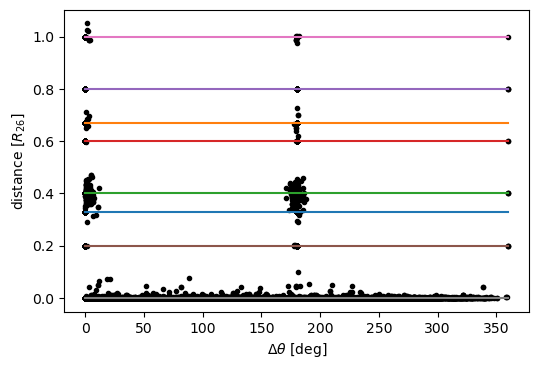

In [80]:
plt.plot([0,360],[0.33,0.33])
plt.plot([0,360],[0.67,0.67])
plt.plot([0,360],[0.4,0.4])
plt.plot([0,360],[0.6,0.6])
plt.plot([0,360],[0.8,0.8])
plt.plot([0,360],[0.2,0.2])
plt.plot([0,360],[1,1])
plt.plot([0,360],[0,0])
plt.scatter(tf_master_table['TARGET_DELTA_PA'], tf_master_table['TARGET_DIST_R26'], marker='.', color='k')
#plt.xlim(359.99,360.01)
plt.xlabel(r'$\Delta \theta$ [deg]')
plt.ylabel(r'distance [$R_{26}$]')
plt.show()

### defining 'EOA' targets
1. not at center or regular target distances (0.33R26, 0.67R26, N X 0.2R26
2. not at center, at regular target distance and target_delta_pa is > 0.001 degrees from 0,180,or 360

In [82]:
#define 'normal' distances
dist = np.array([0,0.2,0.33,0.4,0.6,0.67,0.8,1])
tf_master_table['EOA'] = 0
for i in range(len(tf_master_table)):
    dist_diff = np.abs(tf_master_table['TARGET_DIST_R26'][i] - dist) 
    if len(dist_diff[dist_diff < 0.001]) == 0:
        tf_master_table['EOA'][i] = 1

In [84]:
for i in range(len(tf_master_table)):
    dist_diff = np.abs(tf_master_table['TARGET_DIST_R26'][i] - dist[1:])
    
    if len(dist_diff[dist_diff < 0.001]) > 0 and tf_master_table[i]['TARGET_DELTA_PA'] > 0.001:
        tf_master_table['EOA'][i] = 1

## ignoring everything from before and using the target list

In [29]:
# make a galaxy dict sga
sga_gal_dict = {}
for i in range(len(SGA)):
    sga_gal_dict[SGA['GALAXY'][i]] = i

In [26]:
EOA_targs = Table.read('/pscratch/sd/n/nravi/SGA_off-axis_targets.fits')
EOA_targs[:5]

GALAXY,RA,DEC
bytes11,float64,float64
NGC4761,193.29086531640286,-9.197860127650477
NGC4761,193.25307026043834,-9.187776242212069
NGC4761,193.26884118382742,-9.20154030566786
NGC4761,193.26838380153842,-9.198178779994157
NGC4761,193.27011185413699,-9.199483271700393


In [36]:
EOA_gal_list = np.unique(EOA_targs['GALAXY'])

In [44]:
in_iron_fuji = [] # sga id's of eoa galaxies
not_in_sga = [] # galaxies that couldn't be identified by name in the sga

for i in EOA_gal_list:
    try:
        sga_idx = sga_gal_dict[i]
    except:
        not_in_sga.append(i)
        continue
    sga_id = SGA[sga_idx]['SGA_ID']
    
    if len(tf_master_table[tf_master_table['SGA_ID']==sga_id]) > 0:
        in_iron_fuji.append(sga_id)

In [46]:
len(in_iron_fuji)

159

In [68]:
not_in_sga

['NGC6861', 'NGC6868']

In [80]:
tf_master_table['EOA'] = 0.
# mark all targets related to galaxy as EOA -- remove bad targets by vi later
for sga_id in in_iron_fuji:
    tf_master_table['EOA'][tf_master_table['SGA_ID'] == sga_id] = 1.

In [82]:
tf_master_table[np.logical_and(tf_master_table['EOA'] ==1, tf_master_table['ROT_CURVE'] ==1)]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64
1083283966263312,180.088777358876,-1.11024777720183,25599,sv3,0.00436762087876588,1.42837672240012e-06,0,15897.7449971626,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.08877735887648,-1.1102477772018335,1.0,0.013957389713373361,0.32999998593202395,1.0,1.0
1083283966263313,180.108167612631,-1.09016316641461,25599,sv3,0.0053534602140923,4.45334000484803e-06,0,4136.92135445221,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.10816761263058,-1.090163166414607,1.0,0.013957389713391206,0.3299999859324459,1.0,1.0
1070089826729999,180.078788337759,-1.1205943454118,25599,sv3,0.746080375788651,7.05932471404864e-05,0,12.3854653686285,fuji/healpix/sv3/bright/255/25599/redrock-sv3-bright-25599.fits,EXT,1065602,180.07878833775885,-1.1205943454118001,1.0,0.02833773063017716,0.6699999714376246,1.0,1.0
1083283966263311,180.078788337759,-1.1205943454118,25599,sv3,0.00464639799063975,3.19435285822499e-05,0,31.9120003114913,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.07878833775885,-1.1205943454118001,1.0,0.02833773063017716,0.6699999714376246,1.0,1.0
1083283966263314,180.118156429974,-1.07981649987604,25599,sv3,0.00535718577838891,1.59550379891168e-05,0,249.207345602888,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.11815642997368,-1.0798164998760402,1.0,0.02833773063019543,0.6699999714380566,1.0,1.0
1083429319868418,209.035732273838,4.99637223780072,26090,sv3,0.00455866321424684,1.7045703519496e-05,0,817.973245054869,fuji/healpix/sv3/dark/260/26090/redrock-sv3-dark-26090.fits,EXT,608015,209.03573227383794,4.996372237800723,1.0,0.023405280830906622,0.33000000339582564,1.0,1.0
1087827366379525,209.035732273838,4.99637223780072,26090,sv3,0.00453443262083903,4.65876905121306e-05,0,83.1903149126301,fuji/healpix/sv3/dark/260/26090/redrock-sv3-dark-26090.fits,EXT,608015,209.03573227383794,4.996372237800723,1.0,0.023405280830906622,0.33000000339582564,1.0,1.0
1083429319868419,209.064393717756,5.03346708375066,26090,sv3,0.0037792506419391,1.74096786391594e-06,0,8771.86809350923,fuji/healpix/sv3/dark/260/26090/redrock-sv3-dark-26090.fits,EXT,608015,209.06439371775627,5.033467083750659,1.0,0.023405280830879643,0.3300000033954452,1.0,1.0
1087827366379522,209.064393717756,5.03346708375066,26090,sv3,0.003767532119155,4.11523001920928e-06,0,1584.82943296793,fuji/healpix/sv3/dark/260/26090/redrock-sv3-dark-26090.fits,EXT,608015,209.06439371775627,5.033467083750659,1.0,0.023405280830879643,0.3300000033954452,1.0,1.0


In [83]:
# write table
tf_master_table.write(DATA_DIRECTORY + 'desi_pv_tf_master_table_healpix_rotcurve_EOA.fits', format='fits')

In [84]:
# copy to fuji and iron tables
tf_fuji = Table.read(DATA_DIRECTORY + 'desi_pv_tf_fuji_healpix_rotcurve.fits')
tf_iron = Table.read(DATA_DIRECTORY + 'desi_pv_tf_iron_healpix_rotcurve.fits')                   

In [87]:
tf_fuji['EOA'] = 0.
tf_iron['EOA'] = 0.
for i in range(len(tf_fuji)):
    targid = tf_fuji['TARGETID'][i]
    if tf_master_table['EOA'][tf_master_table['TARGETID'] == targid].all() == 1:
        tf_fuji['EOA'][i] = 1
        
for i in range(len(tf_iron)):
    targid = tf_iron['TARGETID'][i]
    if tf_master_table['EOA'][tf_master_table['TARGETID'] == targid].all() == 1:
        tf_iron['EOA'][i] = 1

In [90]:
tf_fuji.write(DATA_DIRECTORY + 'desi_pv_tf_fuji_healpix_rotcurve_EOA.fits', format='fits')
tf_iron.write(DATA_DIRECTORY + 'desi_pv_tf_iron_healpix_rotcurve_EOA.fits', format='fits')  